Neural Evolutionary Agent for GridWorld RL environment with image observations
Chapter 1, TensorFlow 2 Reinforcement Learning Cookbook | Praveen Palanisamy

In [1]:
from collections import namedtuple

In [2]:
import gym
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm

In [3]:
import envs  # Required to register Gridworld-v0 env

In [4]:
class Brain(keras.Model):
    def __init__(self, action_dim=5, input_shape=(1, 8 * 8)):
        """Initialize the Agent's Brain model

        Args:
            action_dim (int): Number of actions
        """
        super(Brain, self).__init__()
        self.dense1 = layers.Dense(32, input_shape=input_shape, activation="relu")
        self.logits = layers.Dense(action_dim)

    def call(self, inputs):
        x = tf.convert_to_tensor(inputs)
        logits = self.logits(self.dense1(x))
        return logits

    def process(self, observations):
        # Process batch observations using `call(inputs)` behind-the-scenes
        action_logits = self.predict_on_batch(observations)
        return action_logits

In [5]:
class Agent(object):
    def __init__(self, action_dim=5, input_shape=(1, 8 * 8)):
        """Agent with a neural-network brain powered policy

        Args:
            brain (keras.Model): Neural Network based model
        """
        self.brain = Brain(action_dim, input_shape)
        self.brain.compile(
            loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
        )
        self.policy = self.policy_mlp

    def policy_mlp(self, observations):
        observations = observations.reshape(1, -1)
        action_logits = self.brain.process(observations)
        action = tf.random.categorical(tf.math.log(action_logits), num_samples=1)
        return action  # tf.squeeze(action, axis=0)

    def get_action(self, observations):
        return self.policy(observations)

    def learn(self, obs, actions, **kwargs):
        self.brain.fit(obs, actions, **kwargs)

In [6]:
Trajectory = namedtuple("Trajectory", ["obs", "actions", "reward"])

In [7]:
# Evaluate agent in the given environment
def evaluate(agent, env, render=True):
    obs, episode_reward, done, step_num, info = env.reset(), 0.0, False, 0, None
    while not done:
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
        step_num += 1
        if render:
            env.render()
    return step_num, episode_reward, done, info

In [8]:
def rollout(agent, env, render=False):
    """Rollout `agent` in the `environment` for 1 episode
    Args:
        agent (Agent): Agent/policy to generate state-conditioned actions
        env (gym.Env): A Gym environment
        total_steps (int, optional): Totall number of steps to rollout. Defaults to 1000.
        render (bool, optional): Enable/disable rendering. Defaults to False.
    Returns:
        obs_batch (List): Batch of observations collected in the episode
        actions_batch (List): Batch of actions performed in the episode
        episode_reward (float): Total rewards accumulated in this episode
    """
    obs, episode_reward, done, step_num = env.reset(), 0.0, False, 0
    observations, actions = [], []
    episode_reward = 0.0
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, done, info = env.step(action)
        # Save experience
        observations.append(
            np.array(obs).reshape(-1)
        )  # Convert to numpy & reshape (8, 8) to (1, 64)
        actions.append(np.squeeze(action, 0))
        episode_reward += reward

        obs = next_obs
        step_num += 1
        if render:
            env.render()
    env.close()
    return observations, actions, episode_reward

In [9]:
def gather_elite_xp(trajectories, elitism_criterion):
    """Gather elite trajectories from the batch of trajectories
    Args:
        batch_trajectories (List): List of episode trajectories containing experiences (obs, actions, episode_reward)
    Returns:
        elite_batch_obs
        elite_batch_actions
        elite_reard_threshold
    """
    trajectory_obs, trajectory_actions, trajectory_rewards = zip(*trajectories)
    reward_threshold = np.percentile(trajectory_rewards, elitism_criterion)
    indices = [
        index
        for index, value in enumerate(trajectory_rewards)
        if value >= reward_threshold
    ]

    elite_trajectory_obs = [trajectory_obs[i] for i in indices]
    elite_trajectory_actions = [trajectory_actions[i] for i in indices]
    unpacked_elite_batch_obs = [
        item for items in elite_trajectory_obs for item in items
    ]
    unpacked_elite_batch_actions = [
        item for items in elite_trajectory_actions for item in items
    ]
    return (
        np.array(unpacked_elite_batch_obs),
        np.array(unpacked_elite_batch_actions),
        reward_threshold,
    )

In [10]:
def gen_action_distribution(action_index, action_dim=5):
    action_distribution = np.zeros(action_dim).astype(type(action_index))
    action_distribution[action_index] = 1
    # action_distribution = np.expand_dims(action_distribution, 0)
    return action_distribution

In [11]:
def train(
    env_id="Gridworld-v0",
    num_trajectory_rollouts=70,
    elitism_criterion=70,
    num_epochs=10,
):
    """Train Agent in the given Gym `env` using approximate Cross-Entropy

    Args:
        env (str, optional): Name of the Gym environment. Defaults to "Gridworld-v0".
        num_trajectory_rollouts (int, optional): Number of trajectories to rollouts/sample. Defaults to 70.
        elitism_criterion (int, optional): Threshold (as a percentage) to choose elites. Defaults to 70.
        num_epochs (int, optional): Number of epochs to train on the elite trajectories. Defaults to 10.
    """
    num_trajectory_rollouts = num_trajectory_rollouts
    elitism_criterion = elitism_criterion  # Percentage
    num_epochs = num_epochs

    env = gym.make(env_id)
    agent = Agent(env.action_space.n, env.observation_space.shape)

    mean_rewards = []
    elite_reward_thresholds = []
    for i in tqdm(range(num_epochs)):
        trajectories = [
            Trajectory(*rollout(agent, env)) for _ in range(num_trajectory_rollouts)
        ]
        _, _, batch_rewards = zip(*trajectories)
        elite_obs, elite_actions, elite_threshold = gather_elite_xp(
            trajectories, elitism_criterion=elitism_criterion
        )
        elite_action_distributions = np.array(
            [gen_action_distribution(a.item()) for a in elite_actions]
        )
        elite_obs, elite_action_distributions = (
            elite_obs.astype("float16"),
            elite_action_distributions.astype("float16"),
        )
        agent.learn(
            elite_obs, elite_action_distributions, batch_size=128, epochs=3, verbose=0
        )
        mean_rewards.append(np.mean(batch_rewards))
        elite_reward_thresholds.append(elite_threshold)
        print(
            f"Episode#:{i + 1} elite-reward-threshold:{elite_reward_thresholds[-1]:.2f} reward:{mean_rewards[-1]:.2f} "
        )

    plt.plot(mean_rewards, "r-", label="mean_reward")
    plt.plot(elite_reward_thresholds, "g--", label="elites_reward_threshold")
    plt.legend()
    plt.grid()
    plt.show()

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.98s/it]

Episode#:1 elite-reward-threshold:-1.98 reward:-4.13 


100%|██████████| 2/2 [00:23<00:00, 11.82s/it]

100%|██████████| 2/2 [00:23<00:00, 11.72s/it]

Episode#:2 elite-reward-threshold:-1.90 reward:-4.24 


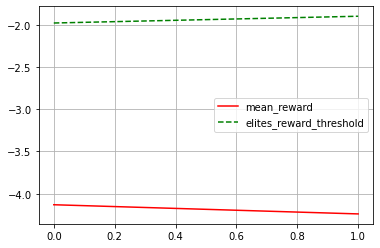

In [12]:
if __name__ == "__main__":
    train(num_epochs=2)  # Increase value of num_epochs